# Spatial Heterogeneity - Endogenous Regimes

### Luc Anselin

### 02/11/2025

## Preliminaries

In this final noteboook devoted to spatial heterogeneity, we consider endogenous regimes obtained as a result of spatially constrained clustering using the *Skater* algorithm. Instead of having the regimes specified beforehand, their optimal configuration is obtained by incorporating the estimation functionality in a Skater clustering algorithm. This is implemented by means of `spreg.OLS_Endog_Regimes`, `spreg.TSLS_Endog_Regimes` and `spreg.GM_Lag_Endog_Regimes`. Since the method is based on a measure of fit, it is not appropriate for error models.

In addition to the same modules as before, we now also use two helper functions to summarize the cluster statistics (`cluster_stats`) and map the cluster layout (`cluster_map`). These helper functions are part of the `spatial_cluster_course` module available from https://github.com/lanselin/notebooks_for_spatial_clustering.

Note that this notebook requires `spreg` version 1.8.2. or later. Use `pip install -U spreg` to get the latest version.

### Modules Needed


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from libpysal.io import open
from libpysal.examples import get_path
from spreg import OLS_Endog_Regimes, GM_Lag_Endog_Regimes
import matplotlib.pyplot as plt

### Functions Used

- from geopandas:
  - read_file
  - plot
  
- from libpysal:
  - libpsyal.examples.get_path
  - libpysal.io.open

- from spreg:
  - OLS_Endog_Regimes
  - GM_Lag_Endog_Regimes

- helper functions:
  - cluster_stats
  - cluster_map

### Data, Weights and Variables

As in the previous notebooks, all data sets, weights files and variables are specified at the top, so that they can be easily changed to other examples.

Data sets and weights are again from the **chicagoSDOH** sample data set:

- **Chi-SDOH.shp,shx,dbf,prj**: socio-economic indicators of health for 2014 in 791 Chicago tracts
- **Chi-SDOH_q.gal**: queen contiguity spatial weights created with *GeoDa*

The weights are used in row-standardized form.

The initial model specification has **YPLL_rate** (an index measuring premature mortality, i.e., higher values are worse health outcomes) as the dependent variable, and **HIS_ct** (economic hardship index), **Blk14P** (percent Black population), and **Hisp14P** 
(percent Hispanic population) as the explanatory variables. Note that there is *no regime variable*. This is determined internally.

The various initializations are carried out in two steps:

- first, all file names and variable names are defined
- second, the files are read and variable vectors/matrices constructed

The first step allows for customization to other examples, the second step is agnostic to the actual files and variables that were specified. To keep the code simple, there are no error checks for missing files or mismatches in the variable names.

#### Specify file and variable names

In [2]:
infileshp = get_path("Chi-SDOH.shp")            # input shape file with data
infileq = get_path("Chi-SDOH_q.gal")            # queen contiguity weights from GeoDa
y_name = 'YPLL_rate'
x_names = ['Blk14P','Hisp14P','HIS_ct']
ds_name = 'Chi-SDOH'
w_name = 'Chi-SDOH_q'

#### Read files and extract variables

In [3]:
dfs = gpd.read_file(infileshp)
wq =  open(infileq).read()    # queen contiguity weights
wq.transform = 'r'    # row-transform the weights
y = dfs[y_name]
x = dfs[x_names]

### Helper Functions

In [4]:
def cluster_stats(clustlabels):
    """
    Creates a data frame with cluster labels and cardinality

    Arguments
    ---------
    clustlabels     : cluster labels from a scikit-learn cluster class

    Returns
    -------
    clustframe      : a pandas dataframe with columns Labels and Cardinality
    """

    totclust,clustcount = np.unique(clustlabels,return_counts=True)
    cl = np.array((totclust,clustcount)).T
    clustframe = pd.DataFrame(data=cl,columns=["Labels","Cardinality"])
    return(clustframe)

In [5]:
def cluster_map(gdf, clustlabels, title='Clusters', grid_shape=(1, 1), figsize=(5, 5), cmap='Set2', show_axis=False, baselayer=None, markersize=10):
    """
    Plot multiple cluster maps in a grid. Can handle both single and multiple maps.

    Arguments
    ---------
    gdf          : geodataframe with the polygons
    clustlabels  : list or single array of cluster labels
    title        : list or single string of titles for each subplot
    grid_shape   : tuple defining the grid layout (default = (1,1))
    figsize      : figure size, default = (5,5)
    cmap         : colormap, default = 'Set2'
    show_axis    : flag to show axis, default = False
    baselayer    : geodataframe with the baselayer, default = None
    markersize   : size of the markers, if any, default = 10

    Returns
    -------
    None
    """
    if not isinstance(clustlabels, (list, tuple)):
        clustlabels = [clustlabels]
    if not isinstance(title, (list, tuple)):
        title = [title]
    
    num_maps = len(clustlabels) 
    
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=figsize)
    axes = np.array(axes).flatten()
    
    for i in range(num_maps):
        gdf_temp = gdf.copy()  
        gdf_temp['cluster'] = np.array(clustlabels[i]).astype(str) 
        if baselayer is not None:
            baselayer.plot(ax=axes[i], color=(1, 1, 1, 0), edgecolor='black')
        gdf_temp.plot(column='cluster', ax=axes[i], legend=True, cmap=cmap,
                      legend_kwds={'bbox_to_anchor': (1, 0.5), 'loc': 'center left'}, markersize=markersize)
        
        if not show_axis:
            axes[i].axis('off') 
        
        axes[i].set_title(title[i]) 
    
    plt.tight_layout()  
    plt.show()  



## OLS with Endogenous Regimes

### Given number of regimes

The first case we consider is when the number of regimes is pre-determined. This is set with the `n_clusters` argument, equal to 4 in the following example. Another important argument that is in addition to the standard OLS regression arguments (`y`,`x`,`wq`,`spat_diag`) is `quorum`. This determines the minimum number of observations in each regime. The default setting is the maximum of either 30 or 10*k, where k is the number of regimes. In the example below, we set `quorum = 100`.

The call to `OLS_Endog_Regimes` creates a regression object that contains all the usual attributes and methods, as well as some additional ones. The coefficient estimates are obtained by means of `print` `summary`. The organization of the output is identical to that for exogenous regimes.

In [6]:
ols1 = OLS_Endog_Regimes(y,x,wq,n_clusters=4,quorum=100,
                         spat_diag=True,name_ds=ds_name,name_w=w_name)
print(ols1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  : 0_YPLL_rate                Number of Observations:         254
Mean dependent var  :   7323.8783                Number of Variables   :           4
S.D. dependent var  :   3372.7662                Degrees of Freedom    :         250
R-squared           :      0.4051
Adjusted R-squared  :      0.3979
Sum squared residual: 1.71219e+09                F-statistic           :     56.7410
Sigma-square        : 6848778.923                Prob(F-statistic)     :     5.2e-28
S.E. of regression  :    2617.017                Log likelihood        :   -2357.321
Sigma-square ML     : 6740924.136                Akaike info criterion :    4722.643
S.E of regression ML:   2596.3290                Schwarz criterion     :    4736.792

----------------

The overall SSR for the four endogenous regimes is 2723916133.42, which compares favorably to the 2857937492.11 obtained for the four exogenous regimes.

In contrast to the results for the exogenous regimes reported in a previous notebook, now the Global Chow test very strongly rejects the null hypothesis of homogeneity, even though there is no evidence of heterogeneity in the ethnic variables. The spatial diagnostics show strong evidence for the inclusion of WX, and some weak evidence for a spatial lag, but not spatial Durbin.

#### Cluster characteristics

In addition to the usual estimates and measures of fit, the regression object created by the endogenous regimes functionality also contains important characteristics of the clusters themselves.

The cluster labels are contained in `clusters`, a numpy array. Note that the cluster labels start at 0, so for four regimes, they go from 0 to 3. We can now use the helper functions `cluster_stats` and `cluster_map` to find the makeup and spatial layout for each cluster.

In [7]:
cluster_stats(ols1.clusters)

,Labels,Cardinality
0,0,254
1,1,115
2,2,284
3,3,138


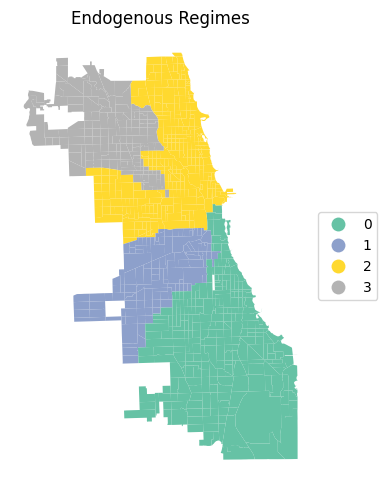

In [8]:
cluster_map(dfs,ols1.clusters,title="Endogenous Regimes")

Another useful piece of information is contained in the `_trace` attribute. It reports on the sequence of steps in the algorithm, i.e., for each *cut* in the minimum spanning tree for the skater algorithm, the resulting cluster labels are given as well as the cut points and the associated value for the objective function. The `_trace` is a list of tuples, consisting of an array with the labels and an internal object with the cut point and `score`.

For example, the status of the algorithm for four regimes is contained in `_trace[3]`, shown below.

In [10]:
ols1._trace[3]

(array([0, 1, 1, 1, 2, 1, 0, 3, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
        3, 3, 1, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 1, 0, 2, 2, 2, 3, 2, 2,
        2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 1, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0,
        1, 0, 3, 3, 3, 3, 3, 3, 3, 0, 0, 1, 1, 2, 1, 3, 3, 3, 3, 3, 2, 0,
        0, 3, 3, 3, 3, 3, 0, 0, 0, 2, 2, 1, 0, 2, 1, 3, 0, 0, 2, 0, 1, 1,
        2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 2, 2, 2, 2,
        2, 0, 1, 2, 2, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 2,
        1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 0, 0, 0, 1, 0, 2,
        0, 1, 1, 0, 2, 3, 1, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 2, 2, 3,
        1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 3, 3, 2, 1,
        1, 1, 2, 3, 0, 0, 2, 3, 3, 3, 

The second item in the tuple contains the value of the objective function. It can be extracted as `_trace[3][1].score`, as shown below. This value is the overall SSR listed in the output. It can be compared for a range of different numbers of regimes, yielding an *elbow plot* to visually identify the optimal number. This is not pursued here. Instead, the *optimal* number of regimes can be determined internally.

In [11]:
print(np.round(ols1._trace[3][1].score,2))

2723916133.42


### Optimal Number of Regimes

When the `n_clusters` argument is not specified, the optimal number of clusters is determined internally, following Mojena's rule. This essentially assesses the improvement in the objective function and stops when it is deemed insufficient.

In order to allow a larger number of clusters, we set the `quorum = 30`. The other arguments are as before.
Before listing the coefficient estimates, we examine some properties of the resulting regimes.

In [12]:
ols2 = OLS_Endog_Regimes(y,x,wq,quorum=30,
                         spat_diag=True,name_ds=ds_name,name_w=w_name)

In [14]:
cluster_stats(ols2.clusters)

,Labels,Cardinality
0,0,161
1,1,99
2,2,49
3,3,33
4,4,119
5,5,210
6,6,50
7,7,32
8,8,38


The optimal number of regimes is obtained as 9, ranging in size from 32 observations to 210 observations. The spatial layout is given by `cluster_map` and we extract the value for the object function as before.

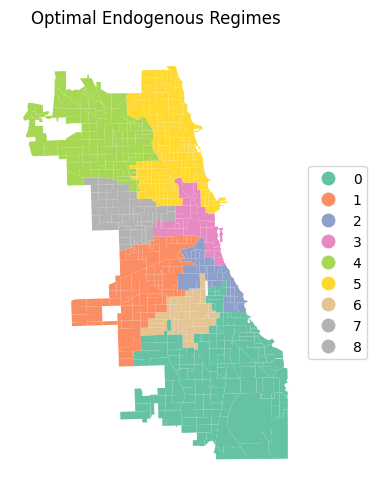

In [15]:
cluster_map(dfs,ols2.clusters,title="Optimal Endogenous Regimes")

In [16]:
print(np.round(ols2._trace[8][1].score,2))

2358809726.99


The coefficients, measures of fit and regression diagnostics follow in the usual way.

In [17]:
print(ols2.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  : 0_YPLL_rate                Number of Observations:         161
Mean dependent var  :   7169.5143                Number of Variables   :           4
S.D. dependent var  :   2385.1356                Degrees of Freedom    :         157
R-squared           :      0.4553
Adjusted R-squared  :      0.4449
Sum squared residual: 4.95824e+08                F-statistic           :     43.7386
Sigma-square        : 3158116.850                Prob(F-statistic)     :   1.332e-20
S.E. of regression  :    1777.109                Log likelihood        :   -1431.146
Sigma-square ML     : 3079654.319                Akaike info criterion :    2870.291
S.E of regression ML:   1754.8944                Schwarz criterion     :    2882.617

----------------

As is to be expected, there is a considerable improvement in the fit relative to four clusters. Also, in this case, coefficient homogeneity is strongly rejected for all but HIS_ct, for which the p-value is <0.04. There is no longer any evidence for a lag alternative, but still strong evidence for the inclusion of WX. This can be implemented in the usual way, by means of `slx_lags=1`, but is not f`urther pursued here.

In the endogenous regimes case, the only option is `constant_regi = 'many'` and `cols2regi = 'all'`. However, since the regime solution is available as the `clusters` attribute, it can be used in any exogenous regimes regression with all the available options.

## Spatial Lag with Endogenous Regimes

Estimation of the spatial lag model with endogenous regimes is implemented in `GM_Lag_Endog_Regimes`. It operates in the same way as for OLS, with the standard arguments for the `GM_Lag` part and the specific arguments for the endogenous regimes aspect. `GM_Lag_Endog_Regimes` is a special case of `TSLS_Endog_Regimes` for a non-spatial regression with endogenous variables. This is not considered separately since it operates in the same way.

Even though there is little/no evidence in the regression diagnostics to motivate a spatial lag model, we briefly illustrate the mechanics.

In [18]:
lag1 = GM_Lag_Endog_Regimes(y,x,wq,n_clusters=4,quorum=100,
                         spat_diag=True,name_ds=ds_name,name_w=w_name)
cluster_stats(lag1.clusters)

,Labels,Cardinality
0,0,199
1,1,115
2,2,339
3,3,138


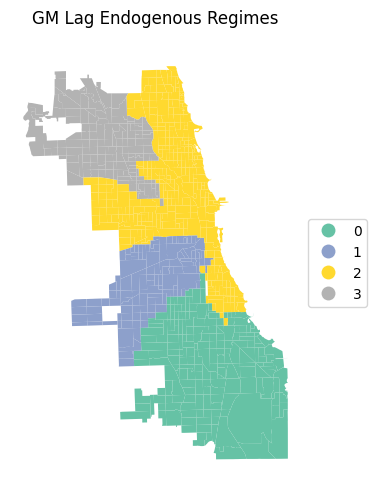

In [19]:
cluster_map(dfs,lag1.clusters,title="GM Lag Endogenous Regimes")

In [20]:
print(lag1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES - REGIMES
------------------------------------------------------------
Data set            :    Chi-SDOH
Weights matrix      :  Chi-SDOH_q
Dependent Variable  :   YPLL_rate                Number of Observations:         791
Mean dependent var  :   5017.1325                Number of Variables   :          17
S.D. dependent var  :   3161.3278                Degrees of Freedom    :         774
Pseudo R-squared    :      0.6567
Spatial Pseudo R-squared:  0.6562

White Standard Errors
------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
          0_CONSTANT      1132.91951       532.67768         2.12684         0.03343
            0_Blk14P        25.87906         6.78120         3.81630         0.00014


As was to be expected, the spatial autoregressive coefficient is not significant. The other results are interpreted in the standard way.

## Practice

Consider the optimal regimes allocation for different spatial weights, i.e., other than queen contiguity. As an exercise, construct an elbow plot from the information in `_trace` and compare your visual inspection to the built-in decision rule. In addition, experiment with the various regime-specific settings, letting some coefficients be fixed and others vary.